In [1]:
##############マウント#####################
from google.colab import drive
import os
import glob

drive.mount('/content/drive/') #マウント
#os.chdir('/drive') #MyDriveにディレクトリ移動
%cd /content/drive/MyDrive
root_path = os.getcwd()
print("root_path : " + str(root_path)) #現在のディレクトリ確認

for name in glob.glob("*"): #ディレクトリ直下のフォルダとファイルを全参照
  print("directries : " + str(name))

print(type(glob.glob("*")))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive
root_path : /content/drive/MyDrive
directries : modo9_kid
directries : pro
directries : yolov5
directries : metropolia
directries : dataset
directries : 2023
directries : sauna!.gslides
directries : FFES_presentation.pptx
directries : self_study
<class 'list'>


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
!pip install tensorflow_addons
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
#データ振り分け
# データセットを読み込む
input_shape = (128, 128, 3) #画像サイズに合わせる
#x_train = np.load('/content/drive/MyDrive/pro/dataset/Xtrain_n_10-01.npy')
#y_train = np.load('/content/drive/MyDrive/pro/dataset/ytrain_n_10-01.npy')
x_train = np.load('/content/drive/MyDrive/pro/err/dataset/x_train.npy')
y_train = np.load('/content/drive/MyDrive/pro/err/dataset/y_train.npy')
x_test = np.load('/content/drive/MyDrive/pro/err/dataset/x_test.npy')
y_test = np.load('/content/drive/MyDrive/pro/err/dataset/y_test.npy')

#データの画像サイズを変更
train_zeros = np.zeros([len(x_train), 128, 128, 3])
test_zeros = np.zeros([len(x_test), 128, 128, 3])
for i in range(len(x_train)):
    train_zeros[i] = np.resize(x_train[i], (128, 128,3))
for i in range(len(x_test)):
    test_zeros[i] = np.resize(x_test[i], (128, 128,3))

# データを正規化する
x_train = train_zeros.astype('float32') / 255.
x_test = test_zeros.astype('float32') / 255.

# 入力データと正解ラベルをランダムにシャッフルする
#np.random.seed(0)
#train_shuffle = np.random.permutation(len(x_train))
#x_train, y_train = x_train[train_shuffle], y_train[train_shuffle]

# データを学習用とテスト用に分割する
#train_size = int(0.8 * len(x_train))
#x_train, x_test = x_train[:train_size], x_train[train_size:]
#y_train, y_test = y_train[:train_size], y_train[train_size:]

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_test.shape)
print('y_val shape:', y_test.shape)

x_train shape: (924, 128, 128, 3)
y_train shape: (924, 2)
x_val shape: (30, 128, 128, 3)
y_val shape: (30, 2)


In [ ]:
#データの用意
num_classes = 2
input_shape = (128, 128, 3) #画像サイズに合わせる

#(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
#x_train = np.load('/content/drive/MyDrive/datasets/ndarray/Xtrain_n_15-01.npy')
x_test = np.load('/content/drive/MyDrive/pro/dataset/Xtest_n_10-01.npy')
#y_train = np.load('/content/drive/MyDrive/datasets/ndarray/ytrain_n_15-01.npy')
y_test = np.load('/content/drive/MyDrive/pro/dataset/ytest_n_10-01.npy')

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#ここから書き足し
print(type(x_train))
print(type(x_test))

x_train shape: (2305, 128, 128, 3) - y_train shape: (2305, 1)
x_test shape: (731, 128, 128, 3) - y_test shape: (731, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
import matplotlib.pyplot as plt

all_images = x_train.shape[0]
for image in range(0, all_images):
  img = x_train[image]
  plt.imshow(img)
  #表示
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [4]:
#パラメータ
learning_rate = 0.01 #default = 0.001
weight_decay = 0.001
batch_size = 512 #default = 256
num_epochs = 1000
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
num_classes = 2
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8 #default = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [5]:
#データ拡張
data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        keras.layers.Resizing(image_size, image_size),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=0.02),
        keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [6]:
#MLPの定義
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=tf.nn.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x


In [7]:
#パッチ作成レイヤー
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        print('rrrrrrrrrrrrrrrrrrrr', images.shape)
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
#画像分割したものを表示
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4)) #プロットする図そのものを定義
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image) #.astype("uint8")
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1])) #分割処理
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    print(patch_img)
    #print(patch_img)
    plt.imshow(patch_img.numpy())
    plt.axis("off")


In [ ]:
print(patches[0][0].shape)
print(patches[0][0])

(108,)
tf.Tensor(
[0.31192207 0.2452554  0.21388283 0.32309368 0.25642702 0.22505447
 0.36762285 0.2912854  0.26958364 0.41567418 0.33442268 0.3255023
 0.45010895 0.367756   0.36143792 0.46192205 0.37737834 0.3821835
 0.31376183 0.24836601 0.21699347 0.3385621  0.2717865  0.24074075
 0.38471317 0.31060275 0.28798115 0.43525782 0.3529049  0.3489107
 0.45849672 0.37614378 0.37614378 0.43485838 0.34858388 0.36034858
 0.32200438 0.25533772 0.22396514 0.34571534 0.2783951  0.25206974
 0.39803922 0.3272452  0.31134108 0.45381263 0.3745461  0.37133867
 0.4550109  0.37265795 0.37265795 0.4160857  0.3298112  0.34260473
 0.3328976  0.26623094 0.2348584  0.3623457  0.2945534  0.26626727
 0.4080005  0.3372549  0.32440087 0.44239894 0.36819172 0.360046
 0.4433551  0.37058824 0.36579522 0.38868314 0.31482694 0.3157468
 0.34335512 0.27745098 0.24607843 0.38104576 0.3137255  0.28594774
 0.42429194 0.3537037  0.34204793 0.4496732  0.3785403  0.36732027
 0.4392157  0.36862746 0.3627451  0.36514163 0.294

In [8]:
#線形化と位置埋め込み
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1) #ポジション番号を生成するだけ
        encoded = self.projection(patch) + self.position_embedding(positions)
        print(f"denced shape: {self.projection(patch).shape}")
        print(f"embedded shape: {self.position_embedding(positions).shape}")
        print(f"encoded shape: {encoded.shape}")
        print(patch.shape)
        print(type(self.projection(patch).shape))
        print(type(self.position_embedding(positions).shape))
        print(type(encoded))
        return encoded

In [9]:
#ViTエンコーダー
def create_vit_classifier():
    inputs = keras.layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented) #inputs
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches) #print(type(encoded_patches))

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.4) #Good = 0.4
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.4)(representation) ####????
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.4) #Good = 0.7
    # Classify outputs.
    logits = keras.layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

rrrrrrrrrrrrrrrrrrrr (None, 72, 72, 3)
denced shape: (None, None, 64)
embedded shape: (144, 64)
encoded shape: (None, 144, 64)
(None, None, 108)
<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
Epoch 1/1000
rrrrrrrrrrrrrrrrrrrr (None, 72, 72, 3)
denced shape: (None, None, 64)
embedded shape: (144, 64)
encoded shape: (None, 144, 64)
(None, None, 108)
<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
rrrrrrrrrrrrrrrrrrrr (None, 72, 72, 3)
denced shape: (None, None, 64)
embedded shape: (144, 64)
encoded shape: (None, 144, 64)
(None, None, 108)
<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
<class 'tensorflow.python.framework.tensor_shape.TensorShape'>
<class 'tensorflow.python.framework.ops.SymbolicTensor'>
2/2

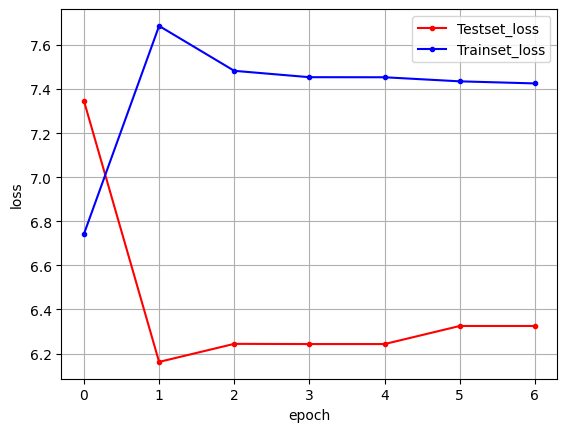

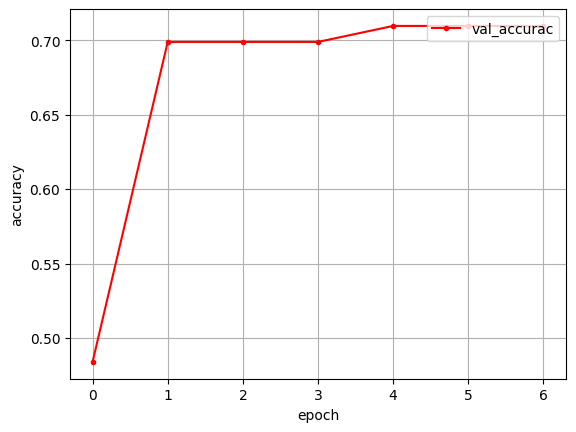

In [10]:
#実行
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss = 'binary_crossentropy', #tf.keras.losses.BinaryCrossentropy(from_logits=False)
        #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'
            #keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            #keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    ##########EarlyStoppingを使う場合はここから先を適宜変更する#############
    checkpoint_filepath = "/tmp/checkpoint"
    #checkpoint_callback = keras.callbacks.ModelCheckpoint(
    #    checkpoint_filepath,
    #    monitor="val_accuracy",
    #    save_best_only=True,
    #    save_weights_only=True,
    #)
    early_stopping_callback = keras.callbacks.EarlyStopping( monitor='val_loss', patience=5)

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping_callback], #callbacks=[checkpoint_callback]
    )
    #model.load_weights(checkpoint_filepath)
    ########################################################################
    _, accuracy = model.evaluate(x_test, y_test) #, top_5_accuracy
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    #print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

#print(model.summary())
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

#####################ここから結果表示##########################
# 検証セットと学習セットの誤差を保存
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# グラフ表現
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# グラフにグリッドを与え、レーベルを表示
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

# 検証セットと学習セットの誤差を保存
y_vloss = history.history['val_accuracy']

# グラフ表現
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='val_accurac')

# グラフにグリッドを与え、レーベルを表示
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
#####################ここから結果表示##########################

In [ ]:
import numpy as np

hoge = np.load("/content/drive/MyDrive/pro/dataset/x_train.npy")
print(hoge.shape)
hoge = np.load("/content/drive/MyDrive/pro/dataset/x_val.npy")
print(hoge.shape)
hoge = np.load("/content/drive/MyDrive/pro/dataset/y_train.npy")
print(hoge.shape)
hoge = np.load("/content/drive/MyDrive/pro/dataset/y_val.npy")
print(hoge.shape)

(240, 256, 256, 1)
(27, 256, 256, 1)
(240, 256, 256, 1)
(27, 256, 256, 1)


In [ ]:
print(hoge)

[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.